In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
colors = sns.color_palette()
import time

In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
def JS_cauchy_closed_form(l1,l2,s1,s2):
    Djs = np.log2(2*np.sqrt((l1-l2)**2 + (s1+s2)**2)/(np.sqrt((l1-l2)**2+(s1+s2)**2) + 2*np.sqrt(s1*s2)))
    return Djs

def find_parameters(Djs):
    # assuming s1 = s2 = 1.0 and l1 = 0.0
    a = 2**Djs 
    l2 = np.sqrt(((2*a)**2)/(2-a)**2-4)
    return l2  

def find_parameters(Djs):
    # assuming s1 = s2 = 1.0 and l1 = 0.0
    a = np.exp(Djs) 
    l2 = np.sqrt(((2*a)**2)/(2-a)**2-4)
    return l2   

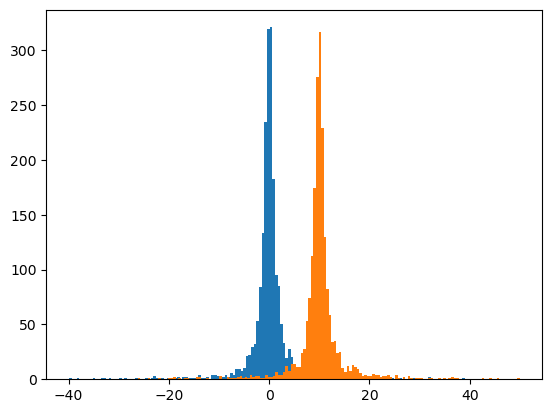

In [4]:
# Number of samples 
n = 2000
# Defining modes of the distributions
l1 = 0
l2 = 10
s1 =1.0
s2 = 1.0
x_samples = stats.cauchy.rvs(loc=l1, scale=s1, size=n) 
y_samples = stats.cauchy.rvs(loc=l2, scale=s2, size=n) 


p1_truncated = x_samples[(x_samples>l1-40) & (x_samples<l1+40)]  # truncate distribution so it plots well
p2_truncated = y_samples[(y_samples>l2-40) & (y_samples<l2+40)]  # truncate distribution so it plots well
plt.hist(p1_truncated,bins = 150)
plt.hist(p2_truncated,bins = 150)
plt.show()

In [5]:
# Create a function that return the data with a desired divergence level
# FOr the mutual information, we need to create Z and L, otherwise return x and y
def get_data(divergence_level,batch_size, to_cuda, retrieve_labels = True):
    l1 = 0
    s1 =1.0
    s2 = 1.0
    l2 = find_parameters(divergence_level)
    x_samples = stats.cauchy.rvs(loc=l1, scale=s1, size=batch_size) 
    y_samples = stats.cauchy.rvs(loc=l2, scale=s2, size=batch_size)
    # Convert data to tensors and send to GPU if needed
    if to_cuda:
        x_samples = torch.from_numpy(x_samples).float().cuda()
        y_samples = torch.from_numpy(y_samples).float().cuda()
    else:
        x_samples = torch.from_numpy(x_samples).float()
        y_samples = torch.from_numpy(y_samples).float()
    # create mixture distribution
    z_samples = torch.cat((x_samples,y_samples),0)
    l_samples = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)),0)
    # make it 2 dimensional
    z_samples = z_samples.unsqueeze(1)
    l_samples = l_samples.unsqueeze(1)
    if retrieve_labels:
        return z_samples.cuda(), l_samples.cuda()
    else:
        return x_samples.view(-1,1).cuda(), y_samples.view(-1,1).cuda()





In [6]:
sample_dim = 1
batch_size = 512 # number of samples per batch
hidden_size = 64 # number of hidden units (neural estimators)
NFF = 64 # Number of Fourier Features to compute JSD
# learning_rate = 0.0075
training_steps = 200

model_list = ["NWJ", "InfoNCE", "CLUB", "MINE", "KNIFE_JS", "RJSD", "RJSD_EMA", "RJSD_no_grad"]
model_names = dict()
model_names = ["NWJ", "InfoNCE", "CLUB", "MINE", "KNIFE JS", "RJSD", "RJSD EMA", "RJSD no grad"] 
is_mi_estimator = [True, True, True, True, False, False,False,False]
learning_rate = [ 0.0075,  0.0075, 0.0075,  0.0075,0.5, 0.0075, 0.0075,  0.0075]
# is_mi_estimator = []


divergence_list = np.log(2)*np.array([0.2,0.4,0.6,0.8,0.95])

total_steps = training_steps*len(divergence_list)

In [7]:
# train MI estimators with samples 
from jsd_estimators import *

In [8]:
mi_results = dict()

for j, model_name in enumerate(model_list):

    if model_name == "KNIFE_JS":
        x_init, y_init = get_data(divergence_list[0], batch_size = batch_size, to_cuda = True, retrieve_labels = is_mi_estimator[j])
        model = eval(model_name)(sample_dim, sample_dim, hidden_size, batch_size, x_init, y_init).cuda()
        optimizer = torch.optim.Adam(model.parameters(), learning_rate[j])
    else:        
        model = eval(model_name)(sample_dim, sample_dim, hidden_size).cuda()
        optimizer = torch.optim.Adam(model.parameters(), learning_rate[j])

    mi_est_values = []

    start_time = time.time()
    for i, divergence_level in enumerate(divergence_list):
        divergence_level = divergence_level
        for step in range(training_steps):
            batch_x, batch_y = get_data(divergence_level, batch_size = batch_size, to_cuda = True, retrieve_labels = is_mi_estimator[j])

            model.eval()

            mi_est_values.append(model(batch_x, batch_y).item())
            
            model.train()
            if model_name == "KNIFE_JS":
                Hx = model.Hx(batch_x)
                Hy = model.Hy(batch_y)
                Hxy = model.Hxy(batch_x, batch_y)
                optimizer.zero_grad()
                Hx.backward()
                Hy.backward()
                Hxy.backward()
                optimizer.step()
            else:
                model_loss = model.learning_loss(batch_x, batch_y)
                if model_name == "RJSD_no_grad":
                    model_loss = model_loss.detach()  
                else:       
                    optimizer.zero_grad()
                    model_loss.backward()
                    optimizer.step()
            
            del batch_x, batch_y
            torch.cuda.empty_cache()

        print("finish training for %s with true MI value = %f" % (model.__class__.__name__, divergence_level))
        # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))
        torch.cuda.empty_cache()
    end_time = time.time()
    time_cost = end_time - start_time
    print("model %s average time cost is %f s" % (model_name, time_cost/total_steps))
    mi_results[model_name] = mi_est_values


finish training for NWJ with true MI value = 0.138629
finish training for NWJ with true MI value = 0.277259
finish training for NWJ with true MI value = 0.415888
finish training for NWJ with true MI value = 0.554518
finish training for NWJ with true MI value = 0.658490
model NWJ average time cost is 0.023281 s
finish training for InfoNCE with true MI value = 0.138629
finish training for InfoNCE with true MI value = 0.277259
finish training for InfoNCE with true MI value = 0.415888
finish training for InfoNCE with true MI value = 0.554518
finish training for InfoNCE with true MI value = 0.658490
model InfoNCE average time cost is 0.023434 s
finish training for CLUB with true MI value = 0.138629
finish training for CLUB with true MI value = 0.277259
finish training for CLUB with true MI value = 0.415888
finish training for CLUB with true MI value = 0.554518
finish training for CLUB with true MI value = 0.658490
model CLUB average time cost is 0.005261 s
finish training for MINE with true

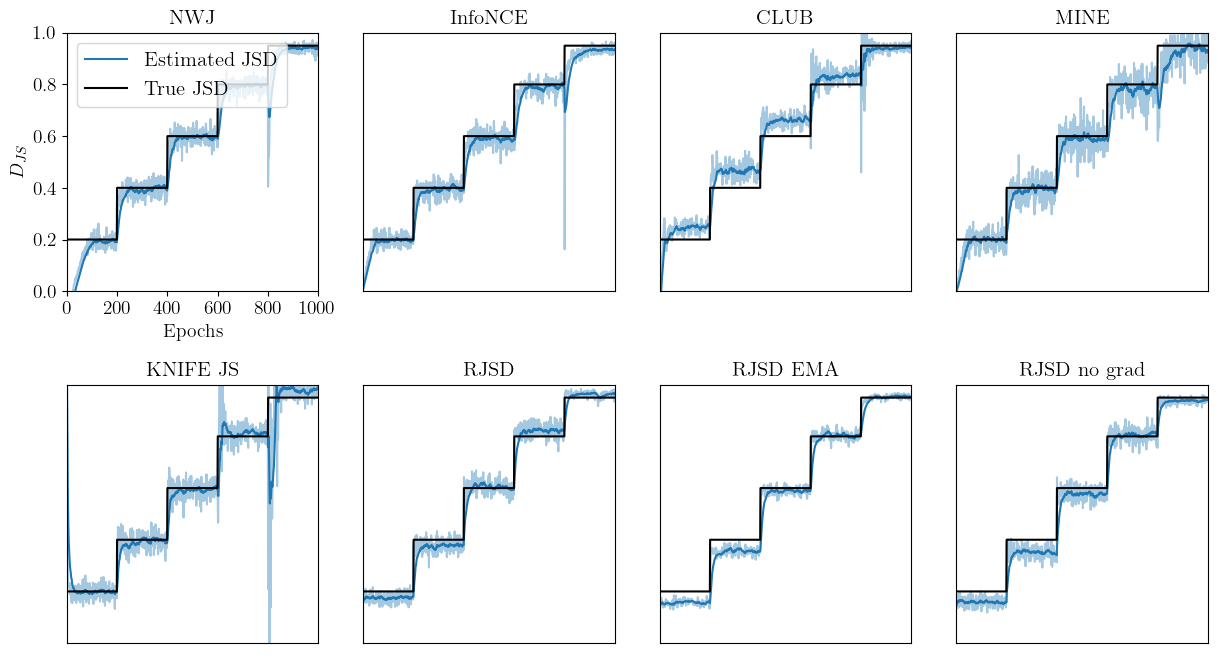

: 

In [11]:
import seaborn as sns
import pandas as pd

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
colors = sns.color_palette()

EMA_SPAN = training_steps//10

ncols = len(model_list)//2
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 *ncols , 3.4 * nrows))
axs = np.ravel(axs)


xaxis = np.array(list(range(total_steps)))
yaxis_mi = np.repeat(divergence_list/np.log(2), training_steps)

for i, model_name in enumerate(model_list):
    plt.sca(axs[i])
    p1 = plt.plot(mi_results[model_name]/np.log(2), alpha=0.4, color=colors[0])[0]  #color = 5 or 0
    mis_smooth = pd.Series(mi_results[model_name]/np.log(2)).ewm(span=EMA_SPAN).mean()
    
    if i == 0:
        plt.plot(mis_smooth, c=p1.get_color(), label='Estimated JSD')
        plt.plot(yaxis_mi, color='k', label='True JSD')
        plt.xlabel('Epochs', fontsize= 14)
        plt.ylabel(r"$D_{JS}$", fontsize = 14)
        plt.ylim(0,1)
        plt.legend(loc='upper left', prop={'size':15})
        plt.xticks([0,training_steps,2*training_steps,3*training_steps,4*training_steps,5*training_steps])
    else:
        plt.plot(mis_smooth, c=p1.get_color())
        # plt.xlabel('Epochs', fontsize= 14)
        plt.yticks([])
        plt.plot(yaxis_mi, color='k')
        plt.ylim(0,1)
        plt.xticks([])
        # plt.xticks([0,200,400,600,800,1000])
    
    plt.ylim(0, 1)
    plt.xlim(0, total_steps)   
    plt.title(model_names[i], fontsize=15)
    #plt.subplots_adjust()

plt.gcf().tight_layout()
# plt.savefig('JSD_Estimation.pdf', dpi=300, bbox_inches='tight')

# Try RJSD without even tuning the parameters

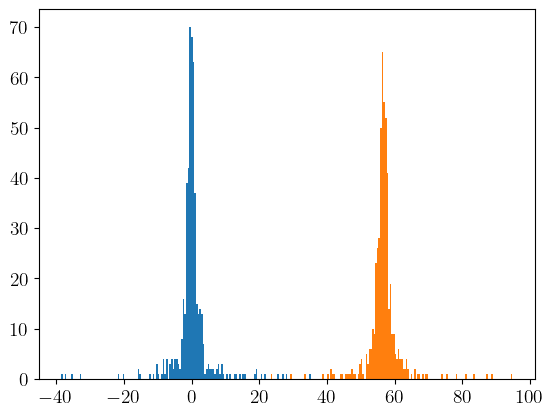

In [10]:
l2 = find_parameters(divergence_level)
x_samples, y_samples = get_data(divergence_level, batch_size = batch_size, to_cuda = True, retrieve_labels = is_mi_estimator[j])
x_samples, y_samples = x_samples.cpu().numpy(), y_samples.cpu().numpy()
p1_truncated = x_samples[(x_samples>l1-40) & (x_samples<l1+40)]  # truncate distribution so it plots well
p2_truncated = y_samples[(y_samples>l2-40) & (y_samples<l2+40)]  # truncate distribution so it plots well
plt.hist(p1_truncated,bins = 150)
plt.hist(p2_truncated,bins = 150)
plt.show()